In [1]:
#install wordcloud if not done already unremark it
#!pip install wordcloud
#!pip install vaderSentiment
#!pip install regex
#!pip install gensim

import nltk
#nltk.download('stopwords')
#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize.casual import casual_tokenize
from nltk.util import ngrams
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np #get the color of the image
from PIL import Image #Load image for wordcloud
from wordcloud import STOPWORDS, ImageColorGenerator
import gensim
from gensim.utils import simple_preprocess

#nltk.download('omw-1.4')

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from wordcloud import WordCloud



In [2]:
#get the different languages and concat into a single df to export to a csv
#added after we discovered that we wanted to get our own dataset.
#This takes the data created in the other notebook that uses Tweepy
df2_es = pd.read_csv("tweets_es.csv")
df2_fr = pd.read_csv("tweets_fr.csv")
df2_en = pd.read_csv("tweets_en.csv")

df2_es['lang'] = 'es' #change for each language
df2_fr['lang'] = 'fr'
df2_en['lang'] = 'en'


merged_df = pd.concat([df2_es, df2_fr, df2_en])

merged_df.to_csv('all_langs_uber_data.csv')
merged_df.head()

created_at  \
0  2022-11-19 10:54:24+00:00   
1  2022-11-19 10:50:35+00:00   
2  2022-11-19 10:49:24+00:00   
3  2022-11-19 10:46:13+00:00   
4  2022-11-19 10:46:13+00:00   

                                                text                 name  \
0                                      uber demorado              bilagol   
1  la de veces que me ha pasado eso cuando salía ...            donatello   
2                            Que Uber gatttttooooooo  EU SOU O NARUTO SIM   
3  Jajsjs tenía plata en la app de Uber, gracias ...            Saturno•🖤   
4                  TA TOCANDO BTS NO UBER PORRAAAAAA        𝕯𝖏 𝕭𝖆𝖈𝖐𝖍𝖔𝖚𝖘𝖊𝖗   

          username location  verified  description lang  
0   oliveiraeulara      NaN       NaN          NaN   es  
1  charliexhiguera      NaN       NaN          NaN   es  
2     edatuaconta1      NaN       NaN          NaN   es  
3   SaturnoHudson3  Uruguay       NaN          NaN   es  
4     KevelyneKPop      NaN       NaN          NaN   es

In [3]:
#Original Dataset from Kaggle stored as "Uber.csv"
df1 = pd.read_csv("Uber.csv")
df1.head()

#Added to consume the new dataset from Tweepy instead of Kaggle
df2 = pd.read_csv("all_langs_uber_data.csv")
df2.head()


#reformatting the new dataset to be closer to what Uber.csv was
df3 = df2[['text','created_at','lang']].copy()
df3.reset_index(inplace=True)
df3 = df3.rename(columns = {'index':'id'})
#df3['lang'] = 'es' #change for each language
df3 = df3.rename(columns = {'id': 'recrd_id'})
df3 = df3.rename(columns = {'text': 'tweet'})
df3 = df3.rename(columns = {'created_at': 'date'})
df3 = df3.rename(columns = {'lang': 'language'})
df3.head()

recrd_id                                              tweet  \
0         0                                      uber demorado   
1         1  la de veces que me ha pasado eso cuando salía ...   
2         2                            Que Uber gatttttooooooo   
3         3  Jajsjs tenía plata en la app de Uber, gracias ...   
4         4                  TA TOCANDO BTS NO UBER PORRAAAAAA   

                        date language  
0  2022-11-19 10:54:24+00:00       es  
1  2022-11-19 10:50:35+00:00       es  
2  2022-11-19 10:49:24+00:00       es  
3  2022-11-19 10:46:13+00:00       es  
4  2022-11-19 10:46:13+00:00       es

In [4]:
#read the data
#df = pd.read_csv("Uber.csv") #originally, this was modified after we changed source
#display(data.head(n=5))
df = df3
#rename column so we have better/easier column names
#df.rename( columns={'Unnamed: 0':'recrd_id'}, inplace=True )

df_trim = df[["recrd_id","tweet","date", "language"]]
idx = df.columns
#print(idx)

#get the unique values from the language column - maybe to use in a loop later
unique_lang_values = df['language'].unique()
print("Unique values in language column:")
print(unique_lang_values)

en_only_data = df_trim[df_trim["language"] == "en"]
print("English tweets df shape")
print(en_only_data.shape) # 3531 tweets in english
#print(en_only_data.columns)

es_only_data = df_trim[df_trim["language"] == "es"]
print("Spanish tweets df shape")
print(es_only_data.shape)

fr_only_data = df_trim[df_trim["language"] == "fr"]
print("French tweets df shape")
print(fr_only_data.shape)

en_only_data.head()

Unique values in language column:
['es' 'fr' 'en']
English tweets df shape
(19367, 4)
Spanish tweets df shape
(7344, 4)
French tweets df shape
(876, 4)


recrd_id                                              tweet  \
8220      8220  Every 51 minutes a human in the US is killed b...   
8221      8221                Uber, but for maintenance painters.   
8222      8222  Yes I'm feeling silly today🤣. I'm kikiki alone...   
8223      8223      My uber driver is really in his sad boy era 😭   
8224      8224  What do you do when you know the local roads b...   

                           date language  
8220  2022-11-19 10:58:58+00:00       en  
8221  2022-11-19 10:58:12+00:00       en  
8222  2022-11-19 10:57:59+00:00       en  
8223  2022-11-19 10:56:44+00:00       en  
8224  2022-11-19 10:56:19+00:00       en

In [5]:
#corpus Definition En, Es, Fr
stop_words = stopwords.words('english')
#print(stop_words)

#stop words that were showing up in our original dataset.  Want them gone, don't need to see https
stop_words.extend(['https','t','s','o','co'])
#print(stop_words)


In [12]:
#Get Stopwords
stpwords = set(STOPWORDS)
stpwords.add('https')
stpwords.add('t')
stpwords.add('s')
stpwords.add('o')
stpwords.add('co')
#stpwords.add('uber')

print(stpwords)

#extract the corpus using casual tokenizer
en_corpus_unormalized = en_only_data.tweet.str.lower()


#lematize each unormalized tweet
lemmatizer = WordNetLemmatizer()

#for each item in unnormalized
#for each split join
#ends with a lemitized list without stopwords
lem_list = []
for i in en_corpus_unormalized:
    lem_list.append(' '.join([lemmatizer.lemmatize(x, pos="v") for x in i.split() if x not in stpwords]))

#normalize the corpus and store it without stop words
en_corpus_wosw = [i for i in lem_list]

lem_list_1 = []
for i in en_corpus_unormalized:
    lem_list_1.append(' '.join([lemmatizer.lemmatize(x, pos="v") for x in i.split()]))

en_corpus = [i.lower() for i in lem_list_1]
#print(lem_list_1)
#print(en_corpus)
#wosw = without stop words
print(en_corpus_wosw)

{"don't", 'nor', 'below', "couldn't", 'could', 'other', 'why', "won't", 'that', 'com', 'off', 'ever', 'this', 'would', 'https', "they're", "we're", 'further', 'if', 'most', 'had', "they'd", 'too', 'as', "how's", 'to', 'cannot', "why's", "they'll", 'since', 'our', "hasn't", 'but', "weren't", 'just', "they've", 'when', 'very', 'them', 'does', "wasn't", 'he', 'her', 'otherwise', "we've", 'his', "she's", 'same', 'then', 'each', "there's", 'yourself', "here's", "we'd", 'whom', 'herself', 'your', 'me', 't', 'about', 'has', 'which', 'of', 'some', 'theirs', 'get', 'during', "isn't", 'or', 'hence', "i've", 'being', "let's", 'out', 'until', 'like', 'at', 'myself', 'my', 'have', 'for', 'should', 'who', 'into', 'over', 'once', "we'll", 'again', "you've", "mustn't", 'after', 'also', 'own', "i'd", "haven't", 'yourselves', 'be', "he'd", 'r', 'no', 'hers', 'up', "when's", 'all', 'itself', "can't", "hadn't", 'more', "you'll", 'their', 'how', 'where', "where's", 'doing', "who's", 'both', 'than', 'the', 

In [7]:
import gensim.corpora as corpora
#id2word = corpora.Dictionary(lem_list)
#print(dict_corpus)
dict_corpus=[]
for i in en_corpus_wosw:
    dict_corpus.append(i.lower().split())
    
print(dict_corpus)

[['every', '51', 'minutes', 'human', 'us', 'kill', 'drink', 'driver.', 'call', 'uber,', 'end', "someone's", 'life.'], ['uber,', 'maintenance', 'painters.'], ['yes', 'feel', 'silly', 'today🤣.', 'kikiki', 'alone.', 'straight', 'face', 'time', 'okare', 'akekwe', 'nix', '🤣.', 'bare', 'nou', 'ngwana', 'take', 'activities', 'vroeg', 'ke', 'uber', 'yena', 'robetse', 'ka', 'ntle', '😎', 'https://t.co/aqyvdmqe7c'], ['uber', 'driver', 'really', 'sad', 'boy', 'era', '😭'], ['know', 'local', 'roads', 'better', 'uber', 'driver', 'see', 'make', 'mistake?'], ['stop', 'use', 'uber', 'past', 'months', 'let', 'charge', 'stupid', 'fee', 'unnecessarily', 'https://t.co/eoeg62dqbw'], ['i’m', 'watch', 'uber', 'interview', 'jay', 'emilien', 'mum', 'walk', 'right', 'show', 'rhe', 'kiss', 'scene', 'talk', 'shove', 'tounges', 'eachother', 'mouth'], ['uber', 'driver', 'tonight', 'tell', 'smell', 'good!', 'das', 'dat', 'lipstick', 'ok!', 'betta', 'know'], ['u', 'wonder', 'happen', 'ur', 'uber', 'driver', 'get', 'pul

In [8]:
#create a dictionary and the tdf corpus for the LDA model

id2word = gensim.corpora.Dictionary(dict_corpus)

tdf_corpus = [id2word.doc2bow(text) for text in dict_corpus]

print(tdf_corpus)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1)], [(11, 1), (13, 1), (14, 1)], [(15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1)], [(36, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1)], [(36, 1), (43, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1)], [(36, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1)], [(36, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1)], [(36, 1), (43, 1), (49, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1)], [(36, 1), (43, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 2), (97, 1)], [(36, 1), 

In [9]:
from pprint import pprint
num_topics = 30

#Build LDA Model
lda_model = gensim.models.LdaMulticore(corpus=tdf_corpus, id2word=id2word, num_topics=num_topics)

pprint(lda_model.print_topics())
doc_lda = lda_model[tdf_corpus]

[(24,
  '0.053*"uber" + 0.018*"driver" + 0.007*"$uber" + 0.007*"play" + 0.005*"go" + '
  '0.005*"i’m" + 0.004*"get" + 0.004*"make" + 0.004*"-" + 0.004*"take"'),
 (17,
  '0.051*"uber" + 0.009*"driver" + 0.009*"get" + 0.006*"drive" + 0.006*"call" '
  '+ 0.004*"go" + 0.004*"think" + 0.004*"take" + 0.004*"&amp;" + '
  '0.004*"$uber"'),
 (2,
  '0.047*"uber" + 0.012*"driver" + 0.010*"i’m" + 0.005*"back" + 0.005*"new" + '
  '0.004*"$uber" + 0.004*"fuck" + 0.003*"get" + 0.003*"try" + 0.003*"ask"'),
 (3,
  '0.033*"uber" + 0.007*"last" + 0.007*"drivers" + 0.006*"ask" + '
  '0.005*"driver" + 0.004*"lose" + 0.004*"check" + 0.004*"want" + 0.004*"seat" '
  '+ 0.004*"go"'),
 (7,
  '0.047*"uber" + 0.013*"driver" + 0.006*"make" + 0.006*"use" + 0.006*"i’m" + '
  '0.005*"drive" + 0.004*"$uber" + 0.004*"take" + 0.004*"back" + '
  '0.004*"never"'),
 (29,
  '0.060*"uber" + 0.018*"driver" + 0.007*"get" + 0.007*"i’m" + 0.006*"go" + '
  '0.006*"drive" + 0.006*"car" + 0.005*"it’s" + 0.005*"call" + 0.004*"$uber"

In [10]:
#Generate visualization of the topics
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

vis = gensimvis.prepare(topic_model = lda_model, corpus=tdf_corpus, dictionary=id2word)
pyLDAvis.enable_notebook()
#output in the notebook
pyLDAvis.display(vis)
#export it to an html file that allows you to see it better.
pyLDAvis.save_html(vis, 'lda.html')

/Users/trey/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/trey/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/trey/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/trey/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/trey/opt/anaconda3/lib/python3.9/site-

/Users/trey/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/trey/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/trey/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/trey/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/trey/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. 

In [13]:
#casual tokenize each line into bigrams
#for each record in en_corpus casual tokenize the sentence
#then bigram the split sentence
#compile into array called bi_grams
bi_grams = [b for i in en_corpus for b in list(ngrams(casual_tokenize(i),2))]

#take the bi_grams and join into a list of bi_grams
bi_grams = [" ".join(x) for x in bi_grams]

#print(bi_grams)

#we could generate topics off the bigrams and trigrams, but decided that could be a future feature.

In [14]:
#casual tokenize each line into trigrams
#for each record in en_corpus casual tokenize the sentence
#then bigram the split sentence
#compile into array called bi_grams
tri_grams = [b for i in en_corpus for b in list(ngrams(casual_tokenize(i),3))]

#take the bi_grams and join into a list of bi_grams
tri_grams = [" ".join(x) for x in tri_grams]

#print(tri_grams)

In [15]:
#if not installed, unremark the install below
#!pip install vaderSentiment

sa = SentimentIntensityAnalyzer()

#add to sentiment list a a score for each in the normalized, lemmetized list (corpus)
#create a dataframe to allow easier manipulation
df_sent_score = pd.DataFrame(en_corpus)
df_sent_score.rename(columns={0:'tweet'}, inplace=True )
list(df_sent_score.columns.values)
#print(df_sent_score)

#Score and analyze the sentiment of each tweet and store in new column
df_sent_score['polarity scores'] = df_sent_score['tweet'].apply(lambda tweet: sa.polarity_scores(tweet))
#select the compound value and place in new column
df_sent_score['compound']  = df_sent_score['polarity scores'].apply(lambda score_dict: score_dict['compound'])
#apply label based on compound column
df_sent_score['label'] = df_sent_score['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')
#apply a sentiment with minimum values
df_sent_score['analysis'] = df_sent_score['compound'].apply(lambda anly: 'Positive' if anly >0.5 else 'Negative' if anly < -0.25 else 'Neutral')


df_sent_score.head()
#df_sent_score.shape


tweet  \
0  every 51 minutes a human in the us be kill by ...   
1                uber, but for maintenance painters.   
2  yes i'm feel silly today🤣. i'm kikiki alone. w...   
3      my uber driver be really in his sad boy era 😭   
4  what do you do when you know the local roads b...   

                                     polarity scores  compound label  analysis  
0  {'neg': 0.19, 'neu': 0.81, 'pos': 0.0, 'compou...   -0.6908   neg  Negative  
1  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...    0.0000   pos   Neutral  
2  {'neg': 0.033, 'neu': 0.715, 'pos': 0.251, 'co...    0.9022   pos  Positive  
3  {'neg': 0.37, 'neu': 0.63, 'pos': 0.0, 'compou...   -0.7553   neg  Negative  
4  {'neg': 0.088, 'neu': 0.806, 'pos': 0.106, 'co...    0.1280   pos   Neutral

In [16]:
tb_counts = df_sent_score.label.value_counts()

tb_counts

pos    13189
neg     6178
Name: label, dtype: int64

In [17]:
vader_counts = df_sent_score['analysis'].value_counts()
vader_counts

Neutral     9850
Negative    4949
Positive    4568
Name: analysis, dtype: int64

In [18]:
#get all positive comments
df_pos_sent = df_sent_score[df_sent_score['analysis']=='Positive']
df_pos_sent.head()
#get all negative comments
df_neg_sent = df_sent_score[df_sent_score['analysis']=='Negative']
df_neg_sent.head()
#get all neutral comments
df_neu_sent = df_sent_score[df_sent_score['analysis']=='Neutral']
df_neu_sent.head()



tweet  \
1                 uber, but for maintenance painters.   
4   what do you do when you know the local roads b...   
6   i’m watch the uber interview with jay and emil...   
8   u ever wonder what happen if ur uber driver ge...   
11  what do you do when you know the local roads b...   

                                      polarity scores  compound label analysis  
1   {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...    0.0000   pos  Neutral  
4   {'neg': 0.088, 'neu': 0.806, 'pos': 0.106, 'co...    0.1280   pos  Neutral  
6   {'neg': 0.0, 'neu': 0.915, 'pos': 0.085, 'comp...    0.4215   pos  Neutral  
8   {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...    0.0000   pos  Neutral  
11  {'neg': 0.088, 'neu': 0.806, 'pos': 0.106, 'co...    0.1280   pos  Neutral

In [19]:
#define and change which sentiment we're analyzing
df_sent_analysis = pd.DataFrame()
df_sent_analysis = df_pos_sent
df_sent_analysis.head()

tweet  \
2   yes i'm feel silly today🤣. i'm kikiki alone. w...   
7   my uber driver tonight tell me i smell good! d...   
9   anyone have uber one?! i’m seriously consider ...   
12  what's goin' on puentsrents family! i'm xx_n0s...   
14  uber reserve want to be your ‘getaway’ car in ...   

                                      polarity scores  compound label  \
2   {'neg': 0.033, 'neu': 0.715, 'pos': 0.251, 'co...    0.9022   pos   
7   {'neg': 0.0, 'neu': 0.821, 'pos': 0.179, 'comp...    0.5399   pos   
9   {'neg': 0.048, 'neu': 0.618, 'pos': 0.333, 'co...    0.8948   pos   
12  {'neg': 0.0, 'neu': 0.784, 'pos': 0.216, 'comp...    0.8939   pos   
14  {'neg': 0.0, 'neu': 0.72, 'pos': 0.28, 'compou...    0.5070   pos   

    analysis  
2   Positive  
7   Positive  
9   Positive  
12  Positive  
14  Positive

In [20]:
#get a wordcloud
text = ' '.join(df_sent_analysis['tweet'])
custom_mask = np.array(Image.open('car.png')) #spain.png france.png US.jpg car.png
stpwords = set(STOPWORDS)
stpwords.add('https')
stpwords.add('t')
stpwords.add('s')
stpwords.add('o')
stpwords.add('co')
#stpwords.add('uber')


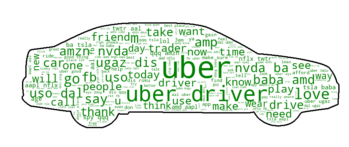

In [21]:


wc = WordCloud(background_color = 'white',
              stopwords = stpwords,
              mask = custom_mask,
              contour_width = 3,
              contour_color = 'black')
wc.generate(text)
image_colors = ImageColorGenerator(custom_mask)
wc.recolor(color_func=lambda *args, **kwargs: (0,128,0) ) #green 0,128,0. red 220,20,60  blue 0,0,205

plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [22]:
df_sent_analysis.head()
print(stpwords)

{"don't", 'nor', 'below', "couldn't", 'could', 'other', 'why', "won't", 'that', 'com', 'off', 'ever', 'this', 'would', 'https', "they're", "we're", 'further', 'if', 'most', 'had', "they'd", 'too', 'as', "how's", 'to', 'cannot', "why's", "they'll", 'since', 'our', "hasn't", 'but', "weren't", 'just', "they've", 'when', 'very', 'them', 'does', "wasn't", 'he', 'her', 'otherwise', "we've", 'his', "she's", 'same', 'then', 'each', "there's", 'yourself', "here's", "we'd", 'whom', 'herself', 'your', 'me', 't', 'about', 'has', 'which', 'of', 'some', 'theirs', 'get', 'during', "isn't", 'or', 'hence', "i've", 'being', "let's", 'out', 'until', 'like', 'at', 'myself', 'my', 'have', 'for', 'should', 'who', 'into', 'over', 'once', "we'll", 'again', "you've", "mustn't", 'after', 'also', 'own', "i'd", "haven't", 'yourselves', 'be', "he'd", 'r', 'no', 'hers', 'up', "when's", 'all', 'itself', "can't", "hadn't", 'more', "you'll", 'their', 'how', 'where', "where's", 'doing', "who's", 'both', 'than', 'the', 

In [24]:
#not sure why I'm getting this error.  Using the head() appears to get all the data correct, so IDK...
df_sent_analysis['tweet'] = df_sent_analysis['tweet_wosw']
df_sent_analysis.head()

/var/folders/g6/wr7hq84j7bq0dvzp40_nxqcm0000gn/T/ipykernel_37787/732073927.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sent_analysis['tweet'] = df_sent_analysis['tweet_wosw']


tweet  \
2   yes feel silly today🤣. kikiki alone. straight ...   
7   uber driver tonight tell smell good! das dat l...   
9   anyone uber one?! i’m seriously consider much ...   
12  goin' puentsrents family! xx_n0sc0pe360_xx com...   
14  uber reserve want ‘getaway’ car holiday heist ...   

                                      polarity scores  compound label  \
2   {'neg': 0.033, 'neu': 0.715, 'pos': 0.251, 'co...    0.9022   pos   
7   {'neg': 0.0, 'neu': 0.821, 'pos': 0.179, 'comp...    0.5399   pos   
9   {'neg': 0.048, 'neu': 0.618, 'pos': 0.333, 'co...    0.8948   pos   
12  {'neg': 0.0, 'neu': 0.784, 'pos': 0.216, 'comp...    0.8939   pos   
14  {'neg': 0.0, 'neu': 0.72, 'pos': 0.28, 'compou...    0.5070   pos   

    analysis                                         tweet_wosw  
2   Positive  yes feel silly today🤣. kikiki alone. straight ...  
7   Positive  uber driver tonight tell smell good! das dat l...  
9   Positive  anyone uber one?! i’m seriously consider much ...  
12  Positive  goin' puentsrents family! xx_n0sc0pe360_xx com...  
14  Positive  uber reserve want ‘getaway’ car holiday heist ...

In [25]:
#create a vector
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
x=vectorizer.fit_transform(df_sent_analysis['tweet'])
x.toarray()

#a step towards getting the eventual tf*idf vector

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [26]:
#get the feature names (the words)
feature_names = vectorizer.get_feature_names_out()
print(feature_names)
len(feature_names)

#get array of words
bow = pd.DataFrame(x.toarray(), columns = vectorizer.get_feature_names_out())

['00' '000' '000s' ... '西澳篇' '轉角做到愛' '野戰']


In [27]:
#get the list of bag of words and their counts
bow_temp = bow
bow_temp.loc['total']=bow_temp.sum(numeric_only=True, axis=0)

bow_totals = bow_temp.transpose().total
print(bow_totals.sort_values(ascending=False))

uber           4796
co             2962
https          2957
driver          820
aapl            507
               ... 
helene            1
helicopters       1
hella             1
helm              1
野戰                1
Name: total, Length: 12935, dtype: int64


In [28]:
#tokenize df_sent_analysis['tweet'] for parse into dictionary
print(en_corpus_wosw)



["every 51 minutes human us kill drink driver. call uber, end someone's life.", 'uber, maintenance painters.', 'yes feel silly today🤣. kikiki alone. straight face time okare akekwe nix 🤣. bare nou ngwana take activities vroeg ke uber yena robetse ka ntle 😎 https://t.co/aqyvdmqe7c', 'uber driver really sad boy era 😭', 'know local roads better uber driver see make mistake?', 'stop use uber past months let charge stupid fee unnecessarily https://t.co/eoeg62dqbw', 'i’m watch uber interview jay emilien mum walk right show rhe kiss scene talk shove tounges eachother mouth', 'uber driver tonight tell smell good! das dat lipstick ok! betta know', 'u wonder happen ur uber driver get pull ur car?', 'anyone uber one?! i’m seriously consider much use love thoughts friends x', 'uber lose billion dollars last six months ask drivers check seat cushion', 'know local roads better uber driver see make mistake?', "goin' puentsrents family! xx_n0sc0pe360_xx comin' ya new makeup tutorial! first, make sure 

In [35]:
from sklearn.decomposition import PCA
#creating the PCA for a dimensionality reduction

In [30]:
feature_names_array = np.array(vectorizer.get_feature_names_out())
print(feature_names_array)

['00' '000' '000s' ... '西澳篇' '轉角做到愛' '野戰']


In [31]:
#Create the inverse doc frequency
from sklearn.feature_extraction.text import TfidfVectorizer

#corpus is array of docs
corpus = df_sent_analysis['tweet']

tfidf_vectorizer = TfidfVectorizer(stop_words='english',min_df = 2)
model = vectorizer.fit_transform(corpus)
print(model.todense().round(2))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [36]:
#define a function to get the top words responded.  Potentially leverage for future features.

def get_top_tf_idf_words(response, top_n=2):
    sorted_nzs = np.argsort(response.data)[:-(top_n+1):-1]
    return feature_names[response.indices[sorted_nzs]]

responses = model
print(responses)
#print([get_top_tf_idf_words(response,2) for response in responses])

  (0, 12696)	1
  (0, 4393)	1
  (0, 10237)	1
  (0, 11307)	1
  (0, 6422)	1
  (0, 1127)	1
  (0, 10672)	1
  (0, 4284)	1
  (0, 11246)	1
  (0, 8161)	1
  (0, 1083)	1
  (0, 7891)	1
  (0, 1653)	1
  (0, 7969)	1
  (0, 7854)	1
  (0, 10945)	1
  (0, 930)	1
  (0, 12125)	1
  (0, 6363)	1
  (0, 11606)	1
  (0, 12694)	1
  (0, 9672)	1
  (0, 6308)	1
  (0, 7998)	1
  (0, 5599)	1
  :	:
  (4565, 1910)	1
  (4565, 11230)	1
  (4565, 9749)	1
  (4565, 2961)	1
  (4565, 7360)	1
  (4565, 5569)	1
  (4565, 8338)	1
  (4565, 4503)	1
  (4565, 3656)	1
  (4565, 3201)	1
  (4565, 2979)	1
  (4565, 9571)	1
  (4566, 11606)	1
  (4566, 3712)	1
  (4566, 8203)	1
  (4566, 4709)	1
  (4566, 1784)	1
  (4566, 11178)	1
  (4566, 10120)	1
  (4566, 5028)	1
  (4566, 6374)	1
  (4567, 11606)	1
  (4567, 3712)	1
  (4567, 2892)	1
  (4567, 1384)	1


In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.casual import casual_tokenize

corpus = df_pos_sent['tweet']
vectorizer = TfidfVectorizer(tokenizer= casual_tokenize)
tfidf_model = vectorizer.fit_transform(corpus).toarray()

len(vectorizer.vocabulary_) #unigram tokens in df_pos_sent

14102

In [41]:
tfidf_model = pd.DataFrame(tfidf_model)

#Denoising: mean removal

tfidf_model = tfidf_model - tfidf_model.mean()
tfidf_model.shape

(4568, 14102)

In [42]:
#situation is ripe for overfitting - need dimensionality reduction

from sklearn.decomposition import PCA
pca = PCA(n_components=50)
pca = pca.fit(tfidf_model)

pca_topic_vectors = pca.transform(tfidf_model)

columns = ['topic{}'.format(i)
          for i in range(pca.n_components)]

pca_topic_vectors = pd.DataFrame(pca_topic_vectors, columns = columns) #need an index?  not sure

pca_topic_vectors.round(3).head(6)


topic0  topic1  topic2  topic3  topic4  topic5  topic6  topic7  topic8  \
0  -0.112  -0.052  -0.007   0.014  -0.031   0.036  -0.009  -0.071   0.164   
1  -0.118   0.025   0.074  -0.015   0.022  -0.002   0.050  -0.113  -0.072   
2  -0.124  -0.045  -0.015  -0.032  -0.019  -0.157   0.102  -0.058  -0.076   
3  -0.138  -0.008   0.614  -0.062   0.090  -0.068  -0.035   0.109   0.107   
4  -0.107  -0.046  -0.042  -0.002  -0.021  -0.026   0.042  -0.027   0.008   
5  -0.121  -0.002  -0.005   0.019  -0.081   0.036  -0.112   0.093   0.015   

   topic9  ...  topic40  topic41  topic42  topic43  topic44  topic45  topic46  \
0   0.116  ...    0.048   -0.009    0.039   -0.004    0.008    0.013    0.014   
1   0.024  ...   -0.102   -0.045    0.093   -0.039   -0.013    0.031    0.058   
2  -0.012  ...   -0.008    0.029    0.035    0.032    0.002   -0.050    0.014   
3  -0.069  ...   -0.006   -0.015   -0.016    0.006    0.008   -0.026   -0.034   
4  -0.017  ...    0.135   -0.045   -0.046    0.006   -0.025   -0.078   -0.017   
5   0.006  ...   -0.004   -0.028    0.048    0.002    0.011   -0.040    0.010   

   topic47  topic48  topic49  
0   -0.025    0.002    0.005  
1   -0.056   -0.020   -0.079  
2   -0.030    0.030   -0.059  
3   -0.008   -0.004   -0.031  
4    0.106    0.002   -0.053  
5    0.031   -0.054    0.021  

[6 rows x 50 columns]

In [43]:
column_nums, terms = zip(*sorted(zip(vectorizer.vocabulary_.values(), vectorizer.vocabulary_.keys())))

In [44]:
weights = pd.DataFrame(pca.components_, columns = terms, index = ['topic{}'.format(i)
          for i in range(pca.n_components)])

weights.head(4)

!         "         #     #0307  #140char      #1sf     #30bg  \
topic0 -0.034594 -0.033000 -0.000488 -0.000074 -0.000021 -0.000058 -0.000061   
topic1  0.145385  0.486591 -0.000609 -0.000086 -0.000031 -0.000079 -0.000093   
topic2  0.509347 -0.057138 -0.001000  0.000034  0.000042  0.000035 -0.000034   
topic3 -0.085796 -0.005367 -0.000003  0.000145  0.000063  0.000125  0.000134   

        #685totheworld  #90dayfiance  #90dayfiancehappilyeverafter  ...  \
topic0       -0.000075     -0.000092                     -0.000092  ...   
topic1       -0.000075     -0.000145                     -0.000145  ...   
topic2       -0.000097     -0.000279                     -0.000279  ...   
topic3       -0.000995     -0.000022                     -0.000022  ...   

               🫠         🫡         🫢         🫣         🫳         🫶        🫶🏻  \
topic0 -0.000981 -0.000439 -0.000101 -0.000394 -0.000070 -0.000270 -0.000291   
topic1 -0.001197 -0.000395 -0.000145 -0.000645 -0.000092 -0.000262 -0.000410   
topic2 -0.001476  0.000211 -0.000307 -0.001274  0.000201 -0.000896 -0.000543   
topic3 -0.002067  0.000896  0.000442 -0.000587  0.000149 -0.001076  0.000626   

              🫶🏼        🫶🏽        🫶🏾  
topic0 -0.000311 -0.000546 -0.000312  
topic1 -0.000417 -0.000657 -0.000380  
topic2 -0.000472 -0.001795 -0.001618  
topic3  0.000552 -0.000461 -0.002411  

[4 rows x 14102 columns]

In [45]:
#get the weights in our pca using targeted words
pd.options.display.max_columns = 20
targeted_words = weights['! love great price best'.split()].round(3)*100

targeted_words

!  love  great  price  best
topic0   -3.5  -1.7   -0.4   -0.2   1.4
topic1   14.5  -1.9   -0.5   -0.3  -0.6
topic2   50.9  -3.7   -0.1   -0.4  -0.7
topic3   -8.6  -0.7    0.4   -0.1   0.2
topic4   12.0  -4.5   -1.5   -0.4  -1.5
topic5  -12.6  -3.0    1.0    0.1   0.3
topic6   12.4   2.0   -1.6   -0.4   0.2
topic7  -19.3  -6.3   -0.4   -0.2  -2.1
topic8  -35.5   0.5   -0.4    0.7  -0.5
topic9   31.6 -11.8   -0.7    0.7  -0.9
topic10   1.8 -10.3   -3.0   -0.2  -1.8
topic11  -4.8  17.8   -0.4   -1.3   0.9
topic12  -8.2  -7.2    0.5    1.4  -0.2
topic13   0.3  -9.2    0.2   -0.1  -1.8
topic14  -1.9 -24.0   -1.2    1.1  -0.9
topic15  -0.6  -7.6   -1.8   -0.3   3.2
topic16   6.8   0.9   -0.6   -0.8  -3.5
topic17   7.9  47.2   -1.0   -1.5   1.9
topic18  -1.9  52.3   -1.5    2.0  -5.4
topic19  -3.0  34.9   -2.6   -0.3  -4.9
topic20   0.5  -2.0   -0.2   -0.7   1.8
topic21   0.2  -0.5   -2.9    0.9  11.1
topic22 -18.1   2.0   -1.2   -0.2  -5.4
topic23  -8.6  -7.2    0.0   -0.5   0.4
topic24  11.2  11.4   -3.3   -0.6  -1.5
topic25  28.8  -3.8   -0.5    0.2 -12.0
topic26 -29.1  -6.1   -2.2   -0.6  -5.9
topic27 -12.8  -5.9   -1.1    0.1  -5.6
topic28  -1.3   3.1   -0.7    0.0  -8.3
topic29  -5.5   7.2   -0.3    0.3  -6.7
topic30 -11.3  -9.0   -0.8   -0.2   4.1
topic31 -14.4  -0.8   -3.3   -0.6  -2.3
topic32  -0.4  -3.0    2.2    0.8   5.4
topic33   0.0 -20.0    4.2   -1.7   5.1
topic34  -4.2   5.9   -4.2    1.1 -10.9
topic35   5.5  -3.1   -0.7   -0.5  -0.7
topic36   0.6  10.5    0.0   -0.3  -1.5
topic37   3.2   0.7   -5.2    0.5  -5.1
topic38   1.1  12.3   -4.9   -0.6   7.8
topic39  -1.4   0.6   -0.2   -3.1   4.2
topic40   4.7   3.2    4.5   -1.6 -18.2
topic41   0.9  -3.2   -7.5   -1.7   8.3
topic42   0.2   1.8    3.3   -2.2 -19.8
topic43   0.9  -0.1   -5.7   -2.5  14.9
topic44   0.8  -1.5   -5.3    0.5 -11.1
topic45   4.2  -0.4   -2.1   -0.1  -2.1
topic46   0.7   2.0   -4.7   -1.2  -3.1
topic47  -1.2   3.7   -7.6    0.5   8.1
topic48  -3.4   0.2  -14.9   -0.6  -6.2
topic49  -5.4   4.1   -6.1    1.9   5.2